<a href="https://colab.research.google.com/github/RaviKcse08/datascience_projs/blob/main/CC_FraudDetection_dataSimulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
# Necessary imports for this notebook
import os

import numpy as np
import pandas as pd

import datetime
import time

import random

# For plotting
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

In [61]:
#create dataframe for customer profiles
def generate_customer_profiles_df(n_customers, random_state=0):
    
    np.random.seed(random_state)
        
    customer_id_properties=[]
    
    # Generate customer properties from random distributions 
    for customer_id in range(n_customers):
        
        x_customer_id = np.random.uniform(0,100)
        y_customer_id = np.random.uniform(0,100)
        
        mean_amount = np.random.uniform(5,100) # Arbitrary (but sensible) value 
        std_amount = mean_amount/2 # Arbitrary (but sensible) value
        
        mean_nb_tx_per_day = np.random.uniform(0,4) # Arbitrary (but sensible) value 
        
        customer_id_properties.append([customer_id,
                                      x_customer_id, y_customer_id,
                                      mean_amount, std_amount,
                                      mean_nb_tx_per_day])
        
    customer_profiles_df = pd.DataFrame(customer_id_properties, columns=['CUSTOMER_ID',
                                                                      'x_customer_id', 'y_customer_id',
                                                                      'mean_amount', 'std_amount',
                                                                      'mean_nb_tx_per_day'])
    
    return customer_profiles_df

In [71]:
#sample dataframe with 5 customers profiles
n_cstmers = 10000
customer_profiles_df = generate_customer_profiles_df(n_cstmers, random_state = 0)
customer_profiles_df.shape

(10000, 6)

In [72]:
#create dataframe for sample terminal profiles
import numpy as np
import pandas as pd
def generate_terminal_profiles_df(n_terminals, random_state=0):
    
    np.random.seed(random_state)
        
    terminal_attributes=[]
    for terminal_id in range(n_terminals):
        
        x_terminal_id = np.random.uniform(0,100)
        y_terminal_id = np.random.uniform(0,100)
        
        terminal_attributes.append([terminal_id,x_terminal_id, y_terminal_id])                                       
    terminal_profiles_df = pd.DataFrame(terminal_attributes, columns=['TERMINAL_ID','x_terminal_id', 'y_terminal_id'])
    
    return terminal_profiles_df

In [73]:
#sample dataframe with 5 terminals
n_terminals = 10000
terminal_profiles_df = generate_terminal_profiles_df(n_terminals, random_state = 0)
terminal_profiles_df.shape

(10000, 3)

In [74]:
# geographical locations of all terminals as a numpy array
x_y_terminals = terminal_profiles_df[['x_terminal_id','y_terminal_id']].values.astype(float)

def get_list_terminals_within_radius(customer_profile, x_y_terminals, r):
    x_y_customer = customer_profile[['x_customer_id','y_customer_id']].values.astype(float) 
    # Squared difference in coordinates between customer and terminal locations
    squared_diff_x_y = np.square(x_y_customer - x_y_terminals)
    # Sum along rows and compute suared root to get distance
    dist_x_y = np.sqrt(np.sum(squared_diff_x_y, axis=1)) 
    # Get the indices of terminals which are at a distance less than r
    available_terminals = list(np.where(dist_x_y<r)[0])  
    # Return the list of terminal IDs
    return available_terminals
    
# And get the list of terminals within radius of 50miles for the last customer
#get_list_terminals_within_radius(customer_profiles_table.iloc[1], x_y_terminals=x_y_terminals, r=50)

In [76]:
#apply attribute available_terminals in customer dataframe
customer_profiles_df['available_terminals']=customer_profiles_df.apply(lambda x : get_list_terminals_within_radius(x, x_y_terminals=x_y_terminals, r=50), axis=1)
customer_profiles_df.shape

(10000, 7)

In [176]:
import random
def generate_transactions_df(customer_profile, start_date = "2023-03-01", nb_days = 2):
    
    customer_transactions = []
    random.seed(int(customer_profile.CUSTOMER_ID))
    np.random.seed(int(customer_profile.CUSTOMER_ID))
    
    # For all days
    for day in range(nb_days):       
        # Random number of transactions for that day 
        nb_tx = np.random.poisson(customer_profile.mean_nb_tx_per_day)  
        # If nb_tx positive, let us generate transactions
        if nb_tx>0:
            for tx in range(nb_tx):
                
                # Time of transaction: Around noon, std 20000 seconds. This choice aims at simulating the fact that 
                # most transactions occur during the day.
                time_tx = int(np.random.normal(86400/2, 20000))
                
                # If transaction time between 0 and 86400, let us keep it, otherwise, let us discard it
                if (time_tx>0) and (time_tx<86400):
                    
                    # Amount is drawn from a normal distribution  
                    amount = np.random.normal(customer_profile.mean_amount, customer_profile.std_amount)
                    
                    # If amount negative, draw from a uniform distribution
                    if amount<0:
                        amount = np.random.uniform(0,customer_profile.mean_amount*2)
                    
                    amount=np.round(amount,decimals=2)
                    
                    if len(customer_profile.available_terminals)>0:
                        
                        terminal_id = random.choice(customer_profile.available_terminals)
                    
                        customer_transactions.append([time_tx+day*86400, day,
                                                      customer_profile.CUSTOMER_ID, 
                                                      terminal_id, amount])
            
    customer_transactions = pd.DataFrame(customer_transactions, columns=['TX_TIME_SECONDS', 'TX_TIME_DAYS', 'CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT'])
    
    if len(customer_transactions)>0:
        customer_transactions['TX_DATETIME'] = pd.to_datetime(customer_transactions["TX_TIME_SECONDS"], unit='s', origin=start_date)
        customer_transactions=customer_transactions[['TX_DATETIME','CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT','TX_TIME_SECONDS', 'TX_TIME_DAYS']]
    
    return customer_transactions  
    
    

In [177]:
#transactions for the given customer, for 2 days, starting at the start_date 
transaction_df=generate_transactions_df(customer_profiles_df.iloc[1], 
                                                         start_date = "2023-03-01", 
                                                         nb_days = 30)
transaction_df.shape
#transaction_df

(121, 6)

In [179]:
#generate the transactions for all customers.
transactions_df=customer_profiles_df.groupby('CUSTOMER_ID').apply(lambda x : generate_transactions_df(x.iloc[0], nb_days=30)).reset_index(drop=True)
transactions_df.shape

(582499, 6)

In [180]:
import time
def generate_dataset(n_customers = 5000, n_terminals = 10000, nb_days=30, start_date="2023-03-01", r=5):
    
    start_time=time.time()
    customer_profiles_table = generate_customer_profiles_df(n_customers, random_state = 0)
    print("Time to generate customer profiles table: {0:.2}s".format(time.time()-start_time))
    
    start_time=time.time()
    terminal_profiles_table = generate_terminal_profiles_df(n_terminals, random_state = 1)
    print("Time to generate terminal profiles table: {0:.2}s".format(time.time()-start_time))
    
    start_time=time.time()
    x_y_terminals = terminal_profiles_table[['x_terminal_id','y_terminal_id']].values.astype(float)
    customer_profiles_table['available_terminals'] = customer_profiles_table.apply(lambda x : get_list_terminals_within_radius(x, x_y_terminals=x_y_terminals, r=r), axis=1)
    # With Pandarallel
    #customer_profiles_table['available_terminals'] = customer_profiles_table.parallel_apply(lambda x : get_list_closest_terminals(x, x_y_terminals=x_y_terminals, r=r), axis=1)
    customer_profiles_table['nb_terminals']=customer_profiles_table.available_terminals.apply(len)
    print("Time to associate terminals to customers: {0:.2}s".format(time.time()-start_time))
    
    start_time=time.time()
    transactions_df=customer_profiles_table.groupby('CUSTOMER_ID').apply(lambda x : generate_transactions_df(x.iloc[0], nb_days=nb_days)).reset_index(drop=True)
    # With Pandarallel
    #transactions_df=customer_profiles_table.groupby('CUSTOMER_ID').parallel_apply(lambda x : generate_transactions_table(x.iloc[0], nb_days=nb_days)).reset_index(drop=True)
    print("Time to generate transactions: {0:.2}s".format(time.time()-start_time))
    
    # Sort transactions chronologically
    transactions_df=transactions_df.sort_values('TX_DATETIME')
    # Reset indices, starting from 0
    transactions_df.reset_index(inplace=True,drop=True)
    transactions_df.reset_index(inplace=True)
    # TRANSACTION_ID are the dataframe indices, starting from 0
    transactions_df.rename(columns = {'index':'TRANSACTION_ID'}, inplace = True)
    
    return (customer_profiles_table, terminal_profiles_table, transactions_df)
    

In [181]:
(customer_profiles_table, terminal_profiles_table, transactions_df)=\
    generate_dataset(n_customers = 5000, 
                     n_terminals = 10000, 
                     nb_days=30, 
                     start_date="2023-03-01", 
                     r=5)

Time to generate customer profiles table: 0.076s
Time to generate terminal profiles table: 0.072s
Time to associate terminals to customers: 3.6s
Time to generate transactions: 4.2e+01s


In [182]:
#dataset with 5000 customers, 10000 terminals for 10 days transactions
transactions_df.shape

(288062, 7)

In [ ]:
#add fraudulent transactions 

In [184]:
def add_frauds(customer_profiles_table, terminal_profiles_table, transactions_df):
    
    # By default, all transactions are genuine
    transactions_df['TX_FRAUD']=0
    transactions_df['TX_FRAUD_SCENARIO']=0
    
    # Scenario 1
    transactions_df.loc[transactions_df.TX_AMOUNT>220, 'TX_FRAUD']=1
    transactions_df.loc[transactions_df.TX_AMOUNT>220, 'TX_FRAUD_SCENARIO']=1
    nb_frauds_scenario_1=transactions_df.TX_FRAUD.sum()
    print("Number of frauds from scenario 1: "+str(nb_frauds_scenario_1))
    
    # Scenario 2
    for day in range(transactions_df.TX_TIME_DAYS.max()):
        
        compromised_terminals = terminal_profiles_table.TERMINAL_ID.sample(n=2, random_state=day)
        
        compromised_transactions=transactions_df[(transactions_df.TX_TIME_DAYS>=day) & 
                                                    (transactions_df.TX_TIME_DAYS<day+28) & 
                                                    (transactions_df.TERMINAL_ID.isin(compromised_terminals))]
                            
        transactions_df.loc[compromised_transactions.index,'TX_FRAUD']=1
        transactions_df.loc[compromised_transactions.index,'TX_FRAUD_SCENARIO']=2
    
    nb_frauds_scenario_2=transactions_df.TX_FRAUD.sum()-nb_frauds_scenario_1
    print("Number of frauds from scenario 2: "+str(nb_frauds_scenario_2))
    
    # Scenario 3
    for day in range(transactions_df.TX_TIME_DAYS.max()):
        
        compromised_customers = customer_profiles_table.CUSTOMER_ID.sample(n=3, random_state=day).values
        
        compromised_transactions=transactions_df[(transactions_df.TX_TIME_DAYS>=day) & 
                                                    (transactions_df.TX_TIME_DAYS<day+14) & 
                                                    (transactions_df.CUSTOMER_ID.isin(compromised_customers))]
        
        nb_compromised_transactions=len(compromised_transactions)
        
        
        random.seed(day)
        index_fauds = random.sample(list(compromised_transactions.index.values),k=int(nb_compromised_transactions/3))
        
        transactions_df.loc[index_fauds,'TX_AMOUNT']=transactions_df.loc[index_fauds,'TX_AMOUNT']*5
        transactions_df.loc[index_fauds,'TX_FRAUD']=1
        transactions_df.loc[index_fauds,'TX_FRAUD_SCENARIO']=3
        
                             
    nb_frauds_scenario_3=transactions_df.TX_FRAUD.sum()-nb_frauds_scenario_2-nb_frauds_scenario_1
    print("Number of frauds from scenario 3: "+str(nb_frauds_scenario_3))
    
    return transactions_df                 

In [185]:
%time transactions_df = add_frauds(customer_profiles_table, terminal_profiles_table, transactions_df)

Number of frauds from scenario 1: 169
Number of frauds from scenario 2: 925
Number of frauds from scenario 3: 595
CPU times: user 4.33 s, sys: 13.6 ms, total: 4.35 s
Wall time: 4.36 s


In [186]:
transactions_df.shape

(288062, 9)

In [187]:
#percentage of fraud transactions
transactions_df.TX_FRAUD.mean()

0.0058633210905985516

In [188]:
def get_stats(transactions_df):
    #Number of transactions per day
    nb_tx_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['CUSTOMER_ID'].count()
    #Number of fraudulent transactions per day
    nb_fraud_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['TX_FRAUD'].sum()
    #Number of fraudulent cards per day
    nb_fraudcard_per_day=transactions_df[transactions_df['TX_FRAUD']>0].groupby(['TX_TIME_DAYS']).CUSTOMER_ID.nunique()
    
    return (nb_tx_per_day,nb_fraud_per_day,nb_fraudcard_per_day)

(nb_tx_per_day,nb_fraud_per_day,nb_fraudcard_per_day)=get_stats(transactions_df)

n_days=len(nb_tx_per_day)
tx_stats=pd.DataFrame({"value":pd.concat([nb_tx_per_day/50,nb_fraud_per_day,nb_fraudcard_per_day])})
tx_stats['stat_type']=["nb_tx_per_day"]*n_days+["nb_fraud_per_day"]*n_days+["nb_fraudcard_per_day"]*n_days
tx_stats=tx_stats.reset_index()

In [189]:
%%capture

sns.set(style='darkgrid')
sns.set(font_scale=1.4)

fraud_and_transactions_stats_fig = plt.gcf()

fraud_and_transactions_stats_fig.set_size_inches(15, 8)

sns_plot = sns.lineplot(x="TX_TIME_DAYS", y="value", data=tx_stats, hue="stat_type", hue_order=["nb_tx_per_day","nb_fraud_per_day","nb_fraudcard_per_day"], legend=False)

sns_plot.set_title('Total transactions, and number of fraudulent transactions \n and number of compromised cards per day', fontsize=20)
sns_plot.set(xlabel = "Number of days since beginning of data generation", ylabel="Number")

sns_plot.set_ylim([0,300])

labels_legend = ["# transactions per day (/50)", "# fraudulent txs per day", "# fraudulent cards per day"]

sns_plot.legend(loc='upper left', labels=labels_legend,bbox_to_anchor=(1.05, 1), fontsize=15)

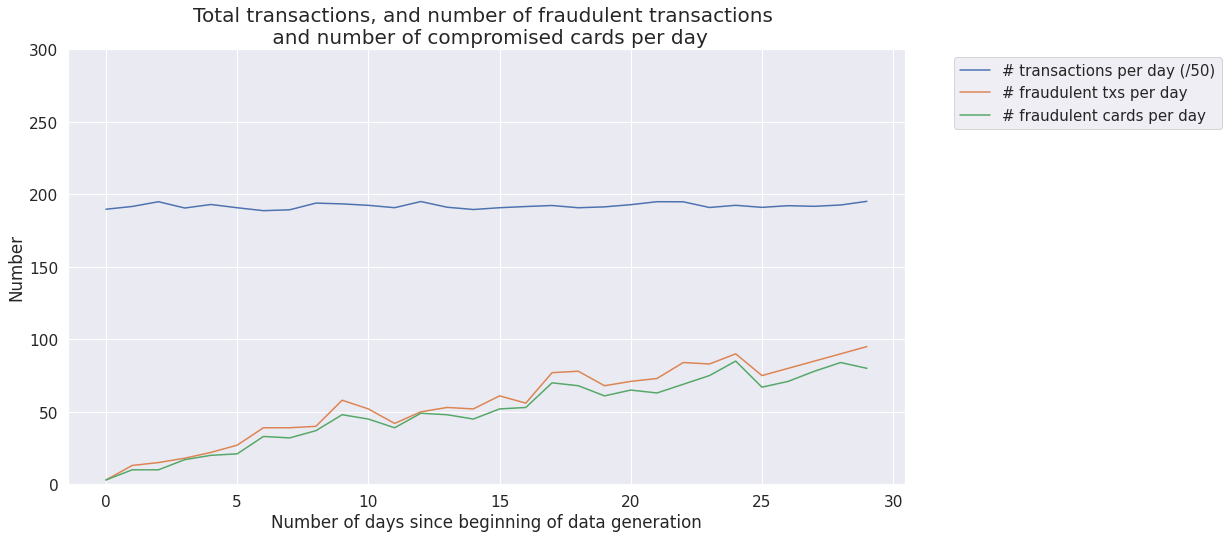

In [190]:

fraud_and_transactions_stats_fig
#simulation generated dataset of 10000 transactions per day. The number of fraudulent transactions per day is around 85

In [145]:

start_date = datetime.datetime.strptime("2023-02-01", "%Y-%m-%d")

for day in range(transactions_df.TX_TIME_DAYS.max()+1):
    
    transactions_day = transactions_df[transactions_df.TX_TIME_DAYS==day].sort_values('TX_TIME_SECONDS')
    
    date = start_date + datetime.timedelta(days=day)
    filename_output = date.strftime("%Y-%m-%d")+'.csv'
    
    # Protocol=4 required for Google Colab
    transactions_day.to_csv(filename_output)

In [191]:
transactions_df.count()

TRANSACTION_ID       288062
TX_DATETIME          288062
CUSTOMER_ID          288062
TERMINAL_ID          288062
TX_AMOUNT            288062
TX_TIME_SECONDS      288062
TX_TIME_DAYS         288062
TX_FRAUD             288062
TX_FRAUD_SCENARIO    288062
dtype: int64

In [150]:
df = pd.read_csv('2023-02-01.csv')
df.shape


(9488, 10)

In [192]:
transactions_df.head

<bound method NDFrame.head of         TRANSACTION_ID         TX_DATETIME CUSTOMER_ID TERMINAL_ID  TX_AMOUNT  \
0                    0 2023-03-01 00:00:31         596        3156      57.16   
1                    1 2023-03-01 00:02:10        4961        3412      81.51   
2                    2 2023-03-01 00:07:56           2        1365     146.00   
3                    3 2023-03-01 00:09:29        4128        8737      64.49   
4                    4 2023-03-01 00:10:34         927        9906      50.99   
...                ...                 ...         ...         ...        ...   
288057          288057 2023-03-30 23:56:58         818        7690      48.92   
288058          288058 2023-03-30 23:57:38        3763        7460      99.06   
288059          288059 2023-03-30 23:57:39        2000        8998      83.24   
288060          288060 2023-03-30 23:58:01        2566        6688     109.55   
288061          288061 2023-03-30 23:58:13        1274        4535      79.02  

In [193]:
def is_weekend(tx_datetime):
    
    # Transform date into weekday (0 is Monday, 6 is Sunday)
    weekday = tx_datetime.weekday()
    # Binary value: 0 if weekday, 1 if weekend
    is_weekend = weekday>=5
    
    return int(is_weekend)

In [194]:
%time transactions_df['TX_DURING_WEEKEND']=transactions_df.TX_DATETIME.apply(is_weekend)

CPU times: user 2.57 s, sys: 15.8 ms, total: 2.59 s
Wall time: 2.59 s


In [195]:
def is_night(tx_datetime):
    
    # Get the hour of the transaction
    tx_hour = tx_datetime.hour
    # Binary value: 1 if hour less than 6, and 0 otherwise
    is_night = tx_hour<=6
    
    return int(is_night)

In [196]:
%time transactions_df['TX_DURING_NIGHT']=transactions_df.TX_DATETIME.apply(is_night)

CPU times: user 4.2 s, sys: 25.1 ms, total: 4.23 s
Wall time: 4.31 s


In [197]:
transactions_df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,TX_DURING_NIGHT
0,0,2023-03-01 00:00:31,596,3156,57.16,31,0,0,0,0,1
1,1,2023-03-01 00:02:10,4961,3412,81.51,130,0,0,0,0,1
2,2,2023-03-01 00:07:56,2,1365,146.00,476,0,0,0,0,1
3,3,2023-03-01 00:09:29,4128,8737,64.49,569,0,0,0,0,1
4,4,2023-03-01 00:10:34,927,9906,50.99,634,0,0,0,0,1


In [199]:
def get_customer_spending_behaviour_features(customer_transactions, windows_size_in_days=[1,7,30]):
    
    # Let us first order transactions chronologically
    customer_transactions=customer_transactions.sort_values('TX_DATETIME')
    
    # The transaction date and time is set as the index, which will allow the use of the rolling function 
    customer_transactions.index=customer_transactions.TX_DATETIME
    
    # For each window size
    for window_size in windows_size_in_days:
        
        # Compute the sum of the transaction amounts and the number of transactions for the given window size
        SUM_AMOUNT_TX_WINDOW=customer_transactions['TX_AMOUNT'].rolling(str(window_size)+'d').sum()
        NB_TX_WINDOW=customer_transactions['TX_AMOUNT'].rolling(str(window_size)+'d').count()
    
        # Compute the average transaction amount for the given window size
        # NB_TX_WINDOW is always >0 since current transaction is always included
        AVG_AMOUNT_TX_WINDOW=SUM_AMOUNT_TX_WINDOW/NB_TX_WINDOW
    
        # Save feature values
        customer_transactions['CUSTOMER_ID_NB_TX_'+str(window_size)+'DAY_WINDOW']=list(NB_TX_WINDOW)
        customer_transactions['CUSTOMER_ID_AVG_AMOUNT_'+str(window_size)+'DAY_WINDOW']=list(AVG_AMOUNT_TX_WINDOW)
    
    # Reindex according to transaction IDs
    customer_transactions.index=customer_transactions.TRANSACTION_ID
        
    # And return the dataframe with the new features
    return customer_transactions

In [200]:
spending_behaviour_customer_0=get_customer_spending_behaviour_features(transactions_df[transactions_df.CUSTOMER_ID==0])
spending_behaviour_customer_0.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,TX_DURING_NIGHT,CUSTOMER_ID_NB_TX_1DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW
TRANSACTION_ID,,,,,,,,,,,,,,,,,
1758,1758,2023-03-01 07:19:05,0,6076,123.59,26345,0,0,0,0,0,1.0,123.590000,1.0,123.590,1.0,123.590
8275,8275,2023-03-01 18:00:16,0,858,77.34,64816,0,0,0,0,0,2.0,100.465000,2.0,100.465,2.0,100.465
8640,8640,2023-03-01 19:02:02,0,6698,46.51,68522,0,0,0,0,0,3.0,82.480000,3.0,82.480,3.0,82.480
12169,12169,2023-03-02 08:51:06,0,6569,54.72,118266,1,0,0,0,0,3.0,59.523333,4.0,75.540,4.0,75.540
15764,15764,2023-03-02 14:05:38,0,7707,63.30,137138,1,0,0,0,0,4.0,60.467500,5.0,73.092,5.0,73.092


In [201]:
%time transactions_df=transactions_df.groupby('CUSTOMER_ID').apply(lambda x: get_customer_spending_behaviour_features(x, windows_size_in_days=[1,7,30]))
transactions_df=transactions_df.sort_values('TX_DATETIME').reset_index(drop=True)

CPU times: user 46.5 s, sys: 410 ms, total: 47 s
Wall time: 47.2 s


In [202]:
transactions_df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,TX_DURING_NIGHT,CUSTOMER_ID_NB_TX_1DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW
0,0,2023-03-01 00:00:31,596,3156,57.16,31,0,0,0,0,1,1.0,57.16,1.0,57.16,1.0,57.16
1,1,2023-03-01 00:02:10,4961,3412,81.51,130,0,0,0,0,1,1.0,81.51,1.0,81.51,1.0,81.51
2,2,2023-03-01 00:07:56,2,1365,146.00,476,0,0,0,0,1,1.0,146.00,1.0,146.00,1.0,146.00
3,3,2023-03-01 00:09:29,4128,8737,64.49,569,0,0,0,0,1,1.0,64.49,1.0,64.49,1.0,64.49
4,4,2023-03-01 00:10:34,927,9906,50.99,634,0,0,0,0,1,1.0,50.99,1.0,50.99,1.0,50.99


In [203]:
transactions_df.shape

(288062, 17)

In [204]:
def get_count_risk_rolling_window(terminal_transactions, delay_period=7, windows_size_in_days=[1,7,30], feature="TERMINAL_ID"):
    
    terminal_transactions=terminal_transactions.sort_values('TX_DATETIME')
    
    terminal_transactions.index=terminal_transactions.TX_DATETIME
    
    NB_FRAUD_DELAY=terminal_transactions['TX_FRAUD'].rolling(str(delay_period)+'d').sum()
    NB_TX_DELAY=terminal_transactions['TX_FRAUD'].rolling(str(delay_period)+'d').count()
    
    for window_size in windows_size_in_days:
    
        NB_FRAUD_DELAY_WINDOW=terminal_transactions['TX_FRAUD'].rolling(str(delay_period+window_size)+'d').sum()
        NB_TX_DELAY_WINDOW=terminal_transactions['TX_FRAUD'].rolling(str(delay_period+window_size)+'d').count()
    
        NB_FRAUD_WINDOW=NB_FRAUD_DELAY_WINDOW-NB_FRAUD_DELAY
        NB_TX_WINDOW=NB_TX_DELAY_WINDOW-NB_TX_DELAY
    
        RISK_WINDOW=NB_FRAUD_WINDOW/NB_TX_WINDOW
        
        terminal_transactions[feature+'_NB_TX_'+str(window_size)+'DAY_WINDOW']=list(NB_TX_WINDOW)
        terminal_transactions[feature+'_RISK_'+str(window_size)+'DAY_WINDOW']=list(RISK_WINDOW)
        
    terminal_transactions.index=terminal_transactions.TRANSACTION_ID
    
    # Replace NA values with 0 (all undefined risk scores where NB_TX_WINDOW is 0) 
    terminal_transactions.fillna(0,inplace=True)
    
    return terminal_transactions

In [205]:
transactions_df[transactions_df.TX_FRAUD==1]

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,TX_DURING_NIGHT,CUSTOMER_ID_NB_TX_1DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW
3527,3527,2023-03-01 10:17:43,3774,3059,225.41,37063,0,1,1,0,0,3.0,158.073333,3.0,158.073333,3.0,158.073333
5789,5790,2023-03-01 13:31:48,4944,6050,222.26,48708,0,1,1,0,0,2.0,127.605000,2.0,127.605000,2.0,127.605000
6549,6549,2023-03-01 14:42:02,4625,9102,226.40,52922,0,1,1,0,0,4.0,167.165000,4.0,167.165000,4.0,167.165000
9583,9583,2023-03-02 01:01:05,3814,6893,59.15,90065,1,1,3,0,1,6.0,29.138333,6.0,29.138333,6.0,29.138333
10356,10356,2023-03-02 05:03:35,2513,1143,222.04,104615,1,1,1,0,1,5.0,123.740000,5.0,123.740000,5.0,123.740000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287475,287475,2023-03-30 20:10:15,4564,1245,58.40,2578215,29,1,3,0,0,2.0,50.675000,12.0,67.493333,48.0,43.378542
287518,287518,2023-03-30 20:19:52,1941,3884,391.40,2578792,29,1,3,0,0,9.0,140.921111,30.0,110.902333,113.0,64.948142
287685,287685,2023-03-30 21:06:54,3391,5185,96.52,2581614,29,1,2,0,0,5.0,60.874000,25.0,54.758800,87.0,58.408046
287706,287706,2023-03-30 21:12:55,365,7691,224.20,2581975,29,1,3,0,0,4.0,115.920000,25.0,91.784800,102.0,70.641078


In [206]:
%time transactions_df=transactions_df.groupby('TERMINAL_ID').apply(lambda x: get_count_risk_rolling_window(x, delay_period=7, windows_size_in_days=[1,7,30], feature="TERMINAL_ID"))
transactions_df=transactions_df.sort_values('TX_DATETIME').reset_index(drop=True)

CPU times: user 1min 55s, sys: 1.64 s, total: 1min 57s
Wall time: 1min 57s


In [207]:
transactions_df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,...,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
0,0,2023-03-01 00:00:31,596,3156,57.16,31,0,0,0,0,...,1.0,57.16,1.0,57.16,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2023-03-01 00:02:10,4961,3412,81.51,130,0,0,0,0,...,1.0,81.51,1.0,81.51,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2023-03-01 00:07:56,2,1365,146.00,476,0,0,0,0,...,1.0,146.00,1.0,146.00,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2023-03-01 00:09:29,4128,8737,64.49,569,0,0,0,0,...,1.0,64.49,1.0,64.49,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2023-03-01 00:10:34,927,9906,50.99,634,0,0,0,0,...,1.0,50.99,1.0,50.99,0.0,0.0,0.0,0.0,0.0,0.0


In [209]:
transactions_df.shape


(288062, 23)

In [210]:
transactions_df.columns

Index(['TRANSACTION_ID', 'TX_DATETIME', 'CUSTOMER_ID', 'TERMINAL_ID',
       'TX_AMOUNT', 'TX_TIME_SECONDS', 'TX_TIME_DAYS', 'TX_FRAUD',
       'TX_FRAUD_SCENARIO', 'TX_DURING_WEEKEND', 'TX_DURING_NIGHT',
       'CUSTOMER_ID_NB_TX_1DAY_WINDOW', 'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW',
       'CUSTOMER_ID_NB_TX_7DAY_WINDOW', 'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW',
       'CUSTOMER_ID_NB_TX_30DAY_WINDOW', 'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW',
       'TERMINAL_ID_NB_TX_1DAY_WINDOW', 'TERMINAL_ID_RISK_1DAY_WINDOW',
       'TERMINAL_ID_NB_TX_7DAY_WINDOW', 'TERMINAL_ID_RISK_7DAY_WINDOW',
       'TERMINAL_ID_NB_TX_30DAY_WINDOW', 'TERMINAL_ID_RISK_30DAY_WINDOW'],
      dtype='object')

In [212]:
transactions_df.to_csv('final_dataset_fd.csv')